# Import Libraries

In [1]:
import community.community_louvain as community
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import math


import os, sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from Utils.utils import shannon_entropy, extract_backbones_and_measures, extract_measures
from Backbones.high_salience_skeleton import high_salience_skeleton as hss
from Backbones.doubly_stochastic import read#, doubly_stochastic as ds
from Backbones.marginal_likelihood_filter import MLF
from Backbones import disparity_filter as disf
from Backbones import h_backbone as hb
#from Backbones import marginal_likelihood_filter as ml
from Backbones.noise_corrected import noise_corrected as nc
from Utils.portrait_divergence import portrait_divergence, portrait_divergence_weighted
%matplotlib inline

# Import the network

In [2]:
#initialize the network name 
network= 'lesmis'

#read edge list from csv file
edge_list = pd.read_csv('../Datasets/' + network + '.csv')
edge_list.weight = edge_list.weight.astype(int)

#read edge list from csv file for the doubly stochastic filter, noice corrected and the high salience skeleton
table, nnodes, nnedges = read("../Datasets/" + network + '.csv', "weight", sep=',', consider_self_loops=False, triangular_input = True, undirected=True) 
table.weight = table.weight.astype(int)  

#create graph from the edge list
G = nx.from_pandas_edgelist(edge_list, edge_attr='weight', create_using=nx.Graph())
#top_10_labels = {name:name for name in pd.DataFrame(G.degree(weight='weight')).sort_values(by=1, ascending=False)[:15][0].to_numpy()}

#edge_list = nx.to_pandas_edgelist(G)

#take only the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
        
original_measures = extract_measures(G)

# Extract the backbones

In [3]:
#initialize the fraction of nodes to be extracted
fractions = [0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.25, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.9, 1]

#initialize the dictionary that contains all backbones
all_backbones_graphs = dict()
all_backbones_measures = dict()

## Global Threshold

In [28]:
#sort edges by weight
backbone = edge_list.copy()
backbone = backbone.sort_values(by='weight', ascending=False)
backbone['threshold'] = backbone['weight']


#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['Global Threshold'] = backbones_dict
all_backbones_measures['Global Threshold'] = backbone_measures


## The Disparity Filter Backbone

In [5]:
#apply the disparity filter algorithm
backbone = disf.disparity_filter(G)

#convert the graph to a dataframe for processing and sort the values by the alpha value
df_backbone = nx.to_pandas_edgelist(backbone)
df_backbone = df_backbone.rename(columns={'alpha': 'threshold'})
df_backbone = df_backbone.sort_values(by='threshold')

#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, df_backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['Disparity Filter'] = backbones_dict
all_backbones_measures['Disparity Filter'] = backbone_measures

## The High Saleince Skeleton

In [6]:
#apply the high salience skeleton algorithm
hss_backbone = hss(table, return_self_loops=False, undirected=True)
    
#sort score values of the edges
hss_backbone = hss_backbone.rename(columns={'score': 'threshold'})
hss_backbone = hss_backbone.sort_values(by='threshold', ascending=False)

#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, hss_backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['High Salience Skeleton'] = backbones_dict
all_backbones_measures['High Salience Skeleton'] = backbone_measures

## The Doubly Stochastic Filter

# Marginal Likelihood Filter

In [7]:
# Apply the transformer to the edgelist
mlf = MLF(directed=False)
mlf_backbone = mlf.fit_transform(edge_list)

#sort score values of the edges
mlf_backbone = mlf_backbone.rename(columns={'significance': 'threshold'})
mlf_backbone = mlf_backbone.sort_values(by='threshold', ascending=False)

#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, mlf_backbone, fractions, 'Edges')

#fix thresholds since they are transformed to log values in the extraction function
backbone_measures['threshold'] = [np.exp(-threshold) for threshold in backbone_measures['threshold']]

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['Marginal Likelihood Filter'] = backbones_dict
all_backbones_measures['Marginal Likelihood Filter'] = backbone_measures

# Noise Corrected Filter

In [8]:
#apply the noise corrected filter
nc_backbone = nc(table, undirected = True, return_self_loops = False, calculate_p_value = False)
nc_backbone['threshold'] = nc_backbone["score"] - (1 * nc_backbone["sdev_cij"])

#sort score values of the edges and take only positive values
nc_backbone = nc_backbone.sort_values(by='threshold', ascending=False)

#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, nc_backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['Noise Corrected Filter'] = backbones_dict
all_backbones_measures['Noise Corrected Filter'] = backbone_measures

## The Polya Filter

In [9]:
#read edge list from csv file
pf_backbone = pd.read_csv('../Results/Backbones Results/PF/' + network + '.csv')

#sort score values of the edges
pf_backbone = pf_backbone.rename(columns={'p_values': 'threshold'})
pf_backbone = pf_backbone.sort_values(by='threshold')

#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, pf_backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['Polya Filter'] = backbones_dict
all_backbones_measures['Polya Filter'] = backbone_measures

## Gloss

In [10]:
#read edge list from csv file
gloss_backbone = pd.read_csv('../Results/Backbones Results/GLOSS/' + network + '.csv', names=['source', 'target', 'threshold', 'weight'], sep=' ')
labels = pd.read_csv('../Datasets/' + network + '_labels.csv', index_col='index')

#relabel using saved labels
labels = labels.T.to_dict('list')
gloss_backbone['source'] = gloss_backbone['source'].replace(labels)
gloss_backbone['target'] = gloss_backbone['target'].replace(labels)

#sort score values of the edges
gloss_backbone = gloss_backbone.sort_values(by='threshold')

#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, gloss_backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['GLOSS Filter'] = backbones_dict
all_backbones_measures['GLOSS Filter'] = backbone_measures

## Lans

## Recast

# Normal Backbone

In [156]:
def calculate_z_scores(node, G, border):
    #extract the second neighborhood of the given node
    g = nx.Graph()
    for neighbor in G.neighbors(node):
        g.add_edge(node, neighbor,weight=G[node][neighbor]['weight'])
        for nneighbor in G.neighbors(neighbor):
            g.add_edge(nneighbor, neighbor,weight=G[nneighbor][neighbor]['weight'])

    #extract all the weight of the second neighborhood
    neighbourhood_weights = list(nx.get_edge_attributes(g, 'weight').values())

    #duplicate the edges when reaching the border
    if G.degree(node) <= border:
        #print(neighbourhood_weights)
        neighbourhood_weights = neighbourhood_weights*2
        #print(neighbourhood_weights)
        
        
    #calculate mean of the weights in the second neighbourhood
    mean = np.mean(neighbourhood_weights)

    #calculate standard deviation of the weights in the second neighbourhood
    stdv = np.std(neighbourhood_weights)

    #loop through the edges of the node and assign the z-scores
    for u,v,weight in g.edges(data='weight'):
        z_score = (weight - mean) / stdv
        if 'z_score'in G[u][v]:
            G[u][v]['z_score'] = max(G[u][v]['z_score'], z_score)
        else:
            G[u][v]['z_score'] = z_score

In [157]:
GG = G.copy()
border = 1
for node in GG.nodes():
    calculate_z_scores(node, GG, border)

In [158]:
z_score_backbone = nx.to_pandas_edgelist(GG)

#sort score values of the edges
z_score_backbone = z_score_backbone.rename(columns={'z_score': 'threshold'})
z_score_backbone = z_score_backbone.sort_values(by='threshold', ascending=False)

In [104]:
#extract different backbones with different network size and calculate the evaluation measures
backbones_dict, backbone_measures = extract_backbones_and_measures(G, z_score_backbone, fractions, 'Edges')

#add the backbone graphs and measures to the all backbones dictionary
all_backbones_graphs['Z-score Filter'] = backbones_dict
all_backbones_measures['Z-score Filter'] = backbone_measures

In [159]:
from scipy import stats

l1 = z_score_backbone.sort_values(by='weight', ascending=False)['threshold'].to_list()[:10]
l2 = df_backbone.sort_values(by='weight', ascending=False)['threshold'].to_list()[:10]


stats.spearmanr(l1, l2)

SpearmanrResult(correlation=-0.6, pvalue=0.06668799999999996)

## Tribe

In [160]:
g = G.copy()

for u, v, w in g.edges(data='weight'):
    #print(u,v, w)
    G[u][v]['disparity'] = df_backbone[((df_backbone['source'] == u) & (df_backbone['target'] == v)) | ((df_backbone['source'] == v) & (df_backbone['target'] == u))]['threshold'].iloc[-1]
    G[u][v]['zscore'] = z_score_backbone[((z_score_backbone['source'] == u) & (z_score_backbone['target'] == v)) | ((z_score_backbone['source'] == v) & (z_score_backbone['target'] == u))]['threshold'].iloc[-1]
    G[u][v]['global'] = backbone[((backbone['source'] == u) & (backbone['target'] == v)) | ((backbone['source'] == v) & (backbone['target'] == u))]['threshold'].iloc[-1]
    
df = nx.to_pandas_edgelist(g)
dd = df.reindex(columns=['source', 'target', 'weight', 'zscore', 'global', 'disparity'])
dd.sort_values(by='weight', ascending=False)[:10]

,source,target,weight,zscore,global,disparity
60,Tholomyes,Cosette,31,7.683002,31,0.000021
143,Pontmercy,Marius,21,4.916511,21,0.027465
145,Eponine,Marius,19,4.363213,19,0.039962
161,Gavroche,Courfeyrac,17,3.809915,17,0.029836
22,Valjean,Javert,17,3.809915,17,0.001296
158,Gavroche,Combeferre,15,3.256617,15,0.023590
20,Valjean,Thenardier,13,2.703319,13,0.008758
188,Marius,Courfeyrac,13,2.703319,13,0.075132
163,Gavroche,Bossuet,12,2.426670,12,0.065306
61,Tholomyes,Marius,12,2.426670,12,0.140074


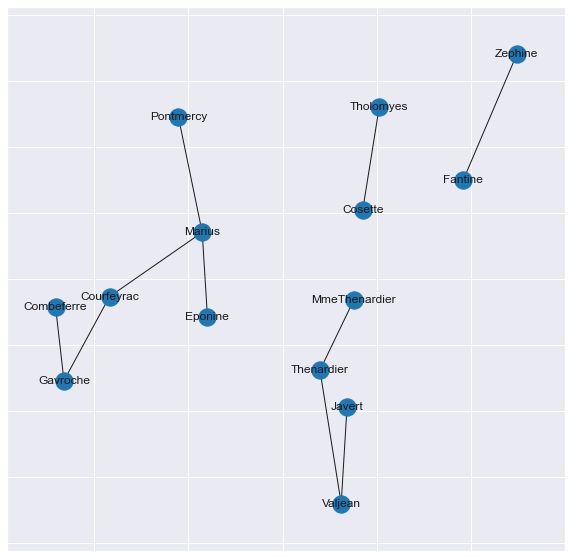

In [161]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
z = nx.from_pandas_edgelist(z_score_backbone.sort_values(by='threshold', ascending=False)[:10])
nx.draw_networkx(z, pos=nx.spring_layout(G,seed=2))

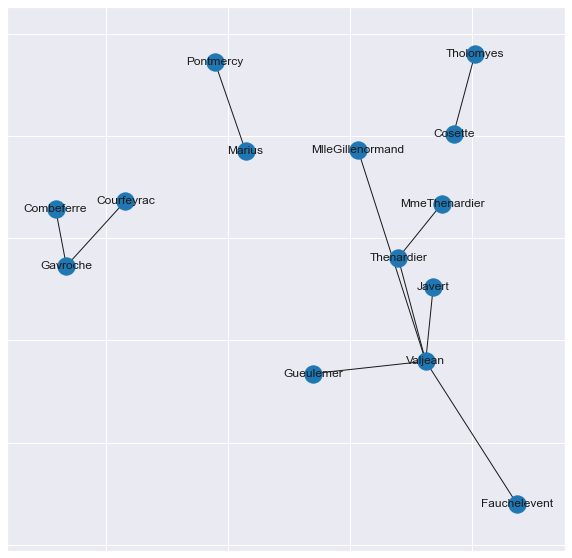

In [162]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
zz = nx.from_pandas_edgelist(df_backbone.sort_values(by='threshold')[:10])
nx.draw_networkx(zz, pos=nx.spring_layout(G,seed=2))

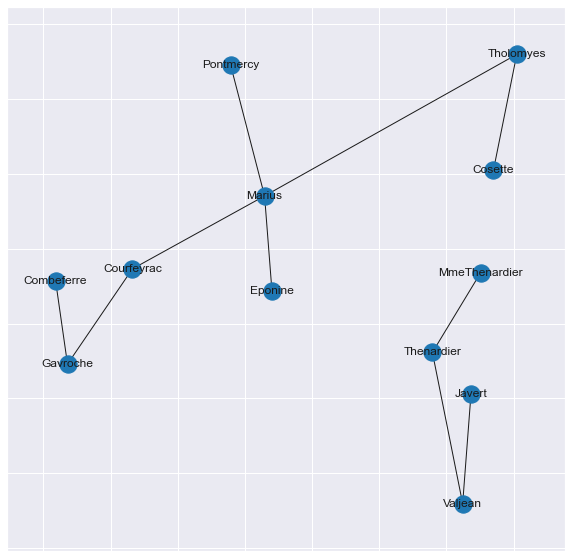

In [163]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
zzz = nx.from_pandas_edgelist(backbone.sort_values(by='threshold', ascending=False)[:10])
nx.draw_networkx(zzz, pos=nx.spring_layout(G,seed=2))

## The h-Backbone

#apply the h-backbone  algorithm and add the h-bridge and h-weight values to the dictionary
h_bridge, h_weight, backbone = hb.h_backbone(G)
    
#create an edge list from the result graph with the scores
h_backbone = nx.to_pandas_edgelist(backbone)

## Zakaria



## Stephany

# Plot and compare the measures

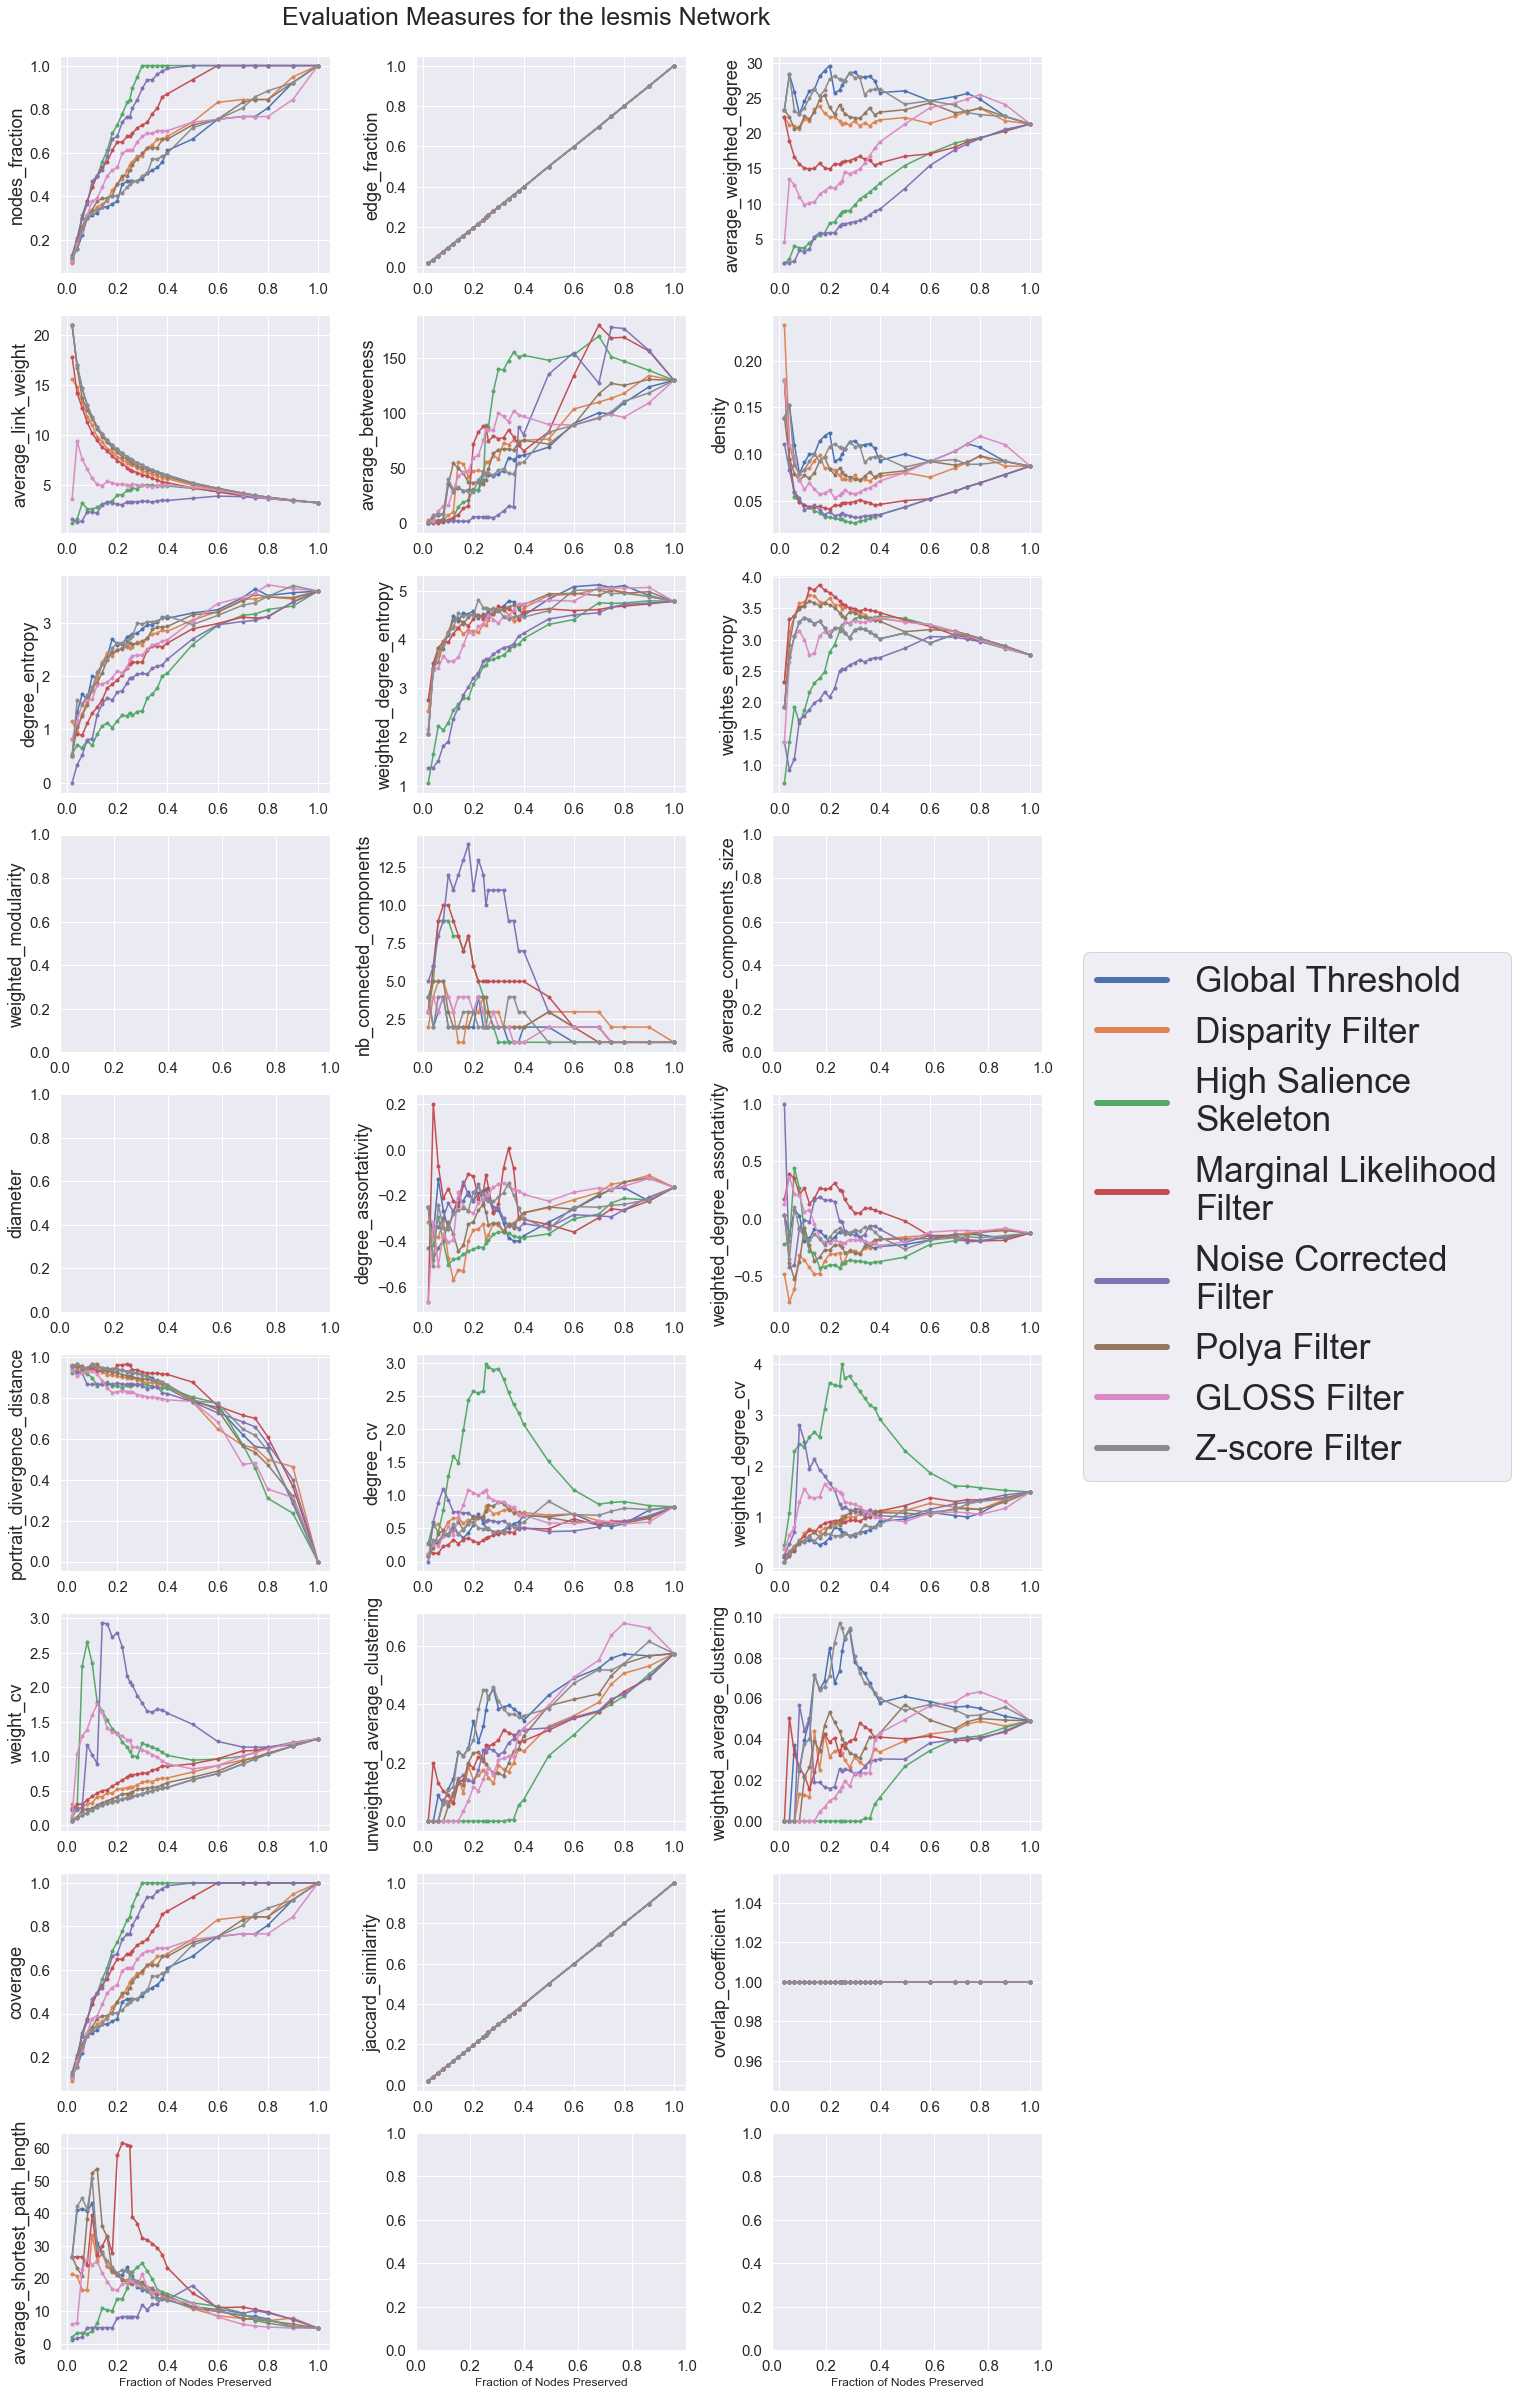

In [16]:
sns.set_theme()
from textwrap import wrap

row = 3
measures = list(all_backbones_measures['Global Threshold'].columns)
measures.remove('threshold')
col = math.ceil(len(all_backbones_measures['Disparity Filter'].columns)/row)
fig, axs = plt.subplots(col, row, figsize=(15,35))


for i, measure in enumerate(measures):
    #i = i+s
    for backbone in all_backbones_measures:
        b = all_backbones_measures[backbone]
        if measure == 'average_components_size' or measure == 'weighted_modularity' or measure =='diameter':
            s= s+1
            #axs[int(i/row), i%row].errorbar(fractions, [b[measure][fraction][0] for fraction in fractions], yerr=[b[measure][fraction][1] for fraction in fractions], label=backbone, marker='o', markersize=3)
            #axs[int(i/row), i%row].plot(fractions, [b[measure][fraction][0] for fraction in fractions], label=backbone, marker='o', markersize=3)

        else:
            axs[int(i/row), i%row].plot(fractions, b[measure], label=backbone, marker='o', markersize=3)
        axs[int(i/row), i%row].set_ylabel(measure, fontsize=18)
    if measure != 'average_components_size' or measure == 'weighted_modularity' or measure =='diameter':
        #axs[int(i/row), i%row].axhline(y=original_measures[measure], color='black', linestyle='--', label='Original Network')
        s=1


plt.setp(axs[-1, :], xlabel='Fraction of Nodes Preserved')#, labelsize=20)
fig.suptitle('Evaluation Measures for the ' + network +' Network', fontsize=25);

for ax in axs.reshape(-1):
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    #ax.set_xticklabels(fractions)
    ax.grid(True)
    
    
handles, labels = axs[0,1].get_legend_handles_labels()
labels = [ '\n'.join(wrap(l, 20)) for l in labels]
lg = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=35)
 
# lg = fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.05), fontsize=25, ncol=8)

for line in lg.get_lines():
    line.set_linewidth(6)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])

#plt.savefig('../Results/Figures/All/Topological/' + network + '.png')

In [ ]:
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt

# G = some networkx graph
fraction=0.3
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)                                                     
                                                                                                 
plt.figure(1)   

# # prep axes                                                                                                                      
# plt.xlabel('degree')                                                                                                             
# plt.xscale('log')                                                                                                                
# plt.xlim(0, max(x))  
                                                                                                           
# plt.ylabel('frequency')                                                                                                          
# plt.yscale('log')                                                                                                                
# plt.ylim(0, max(y)+1)                                                                                                           
#                                                                                                                                      # do plot                                                                                                                        
# plt.scatter(x, y, marker='.', color='black', label='original') 

d=[]
for backbone in all_backbones_graphs.keys():
    b = all_backbones_graphs[backbone][fraction]
    degrees = list(dict(b.degree()).values())
#     degree_counts = Counter(degrees)                                                                                                 
#     x, y = zip(*degree_counts.items())
#     plt.scatter(x, y, marker='.', label='backbone') 
# plt.bar(*np.unique(degree_sequence, return_counts=True))
    d.append(degrees)
sns.displot(data=d, kind='kde', legend=False)



#sns.displot(data=degree_sequence, kind='kde')
# plt.title("Degree histogram")
# plt.xlabel("Degree")
# plt.ylabel("# of Nodes")
plt.legend(labels=all_backbones_graphs.keys())




plt.show()

## SIR Analysis

In [ ]:
# Import those libraries
from scipy.stats import pearsonr

# Import the sir simulations results
sir_results = pd.read_csv("../Results/Epidemic Simulations Resutls/" +network+ ".csv")

# Select the backbones with all the edges of the network
full_backbones = {backbone:all_backbones_graphs[backbone][1] for backbone in all_backbones_graphs.keys()}

#initialize the correlation dataframe
df = pd.DataFrame(columns=full_backbones.keys(), index=['infection_participation'])

#add the infection participation to the backbone graphs
for backbone in full_backbones:
    b = full_backbones[backbone]
    for u, v in b.edges():
        b[u][v]['infection_participation'] = sir_results[((sir_results['source'] == u) & (sir_results['target'] == v)) | ((sir_results['source'] == v) & (sir_results['target'] == u))]['infection_participation'].iloc[0]

    df_backbone = nx.to_pandas_edgelist(b)
    backbone_scores = df_backbone['threshold']
    sir_scores = df_backbone['infection_participation']
    df[backbone] = [pearsonr(backbone_scores, sir_scores)[0]]    
    

In [ ]:
df = df.T
#df['infection_participation'] = df['infection_participation'].abs()
df.sort_values(by='infection_participation', ascending=False)
df.to_csv('../Results/Figures/All/Diffusion/'+network+'.csv')

In [ ]:
df

In [1]:
import scipy.stats as stats
x1 = [12, 2, 1, 12, 2]
x2 = [1, 4, 7, 1, 0]
tau, p_value = stats.kendalltau(x1, x2)
tau

p_value

0.2827454599327748

In [2]:
import scipy.stats as stats
x1 = ['a', 'b', 'c', 'a', 'b']
x2 = ['c', 'e', 'd', 'c', 'f']
tau, p_value = stats.kendalltau(x1, x2)
tau

p_value

0.2827454599327748